In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# 导入数据集
from torchvision.datasets import MNIST
import torch

# 设置随机种子
torch.manual_seed(3306)

# 数据预处理
from torchvision import transforms
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为 Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 下载 MNIST 数据集
mnist_train = MNIST(root='./dataset_file/mnist_raw', train=True, download=True,transform=transform)
mnist_test = MNIST(root='./dataset_file/mnist_raw', train=False, download=True,transform=transform)
# 查看数据集大小
print(f"MNIST train dataset size: {len(mnist_train)}")
print(f"MNIST test dataset size: {len(mnist_test)}")

MNIST train dataset size: 60000
MNIST test dataset size: 10000


(28, 28)


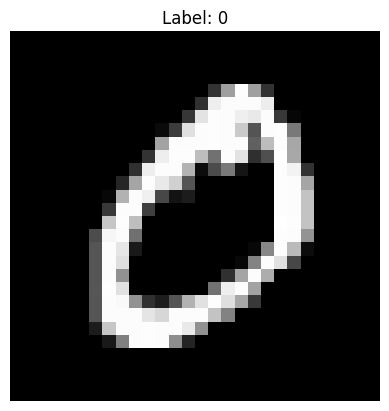

In [9]:
# 查看图片
import matplotlib.pyplot as plt


def show_image(id):
    img, label = mnist_train[id]
    img = img.squeeze().numpy()  # 去掉通道维度
    print(img.shape)
    # print(img)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

show_image(1)

In [10]:
# 数据加载器
from torch.utils.data import DataLoader
from lib.model.DigitModel import DigitLinear,DigitCNN
# 定义数据加载器
batch_size = 256
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

epoch = 50
# 训练模型
# net = DigitLinear() # 参数量1M 97.50%
net = DigitCNN() # 参数量8M 98.35%
net.cuda()


# 定义损失函数和优化器
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# 训练函数

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # 设置模型为训练模式
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs= inputs.cuda()
            y = torch.tensor(torch.zeros((inputs.shape[0],10), dtype=torch.float)).cuda()
            y[torch.arange(inputs.shape[0]), labels] = 1
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.cuda()).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# 训练模型
train_model(net, train_loader, criterion, optimizer, num_epochs=epoch)
            


C:\Users\Leezed\AppData\Local\Temp\ipykernel_33804\3207467027.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.zeros((inputs.shape[0],10), dtype=torch.float)).cuda()


Epoch [1/50], Loss: 0.6653, Accuracy: 82.75%
Epoch [2/50], Loss: 0.2647, Accuracy: 92.28%
Epoch [3/50], Loss: 0.2012, Accuracy: 94.00%
Epoch [4/50], Loss: 0.1675, Accuracy: 95.07%
Epoch [5/50], Loss: 0.1477, Accuracy: 95.61%
Epoch [6/50], Loss: 0.1310, Accuracy: 96.15%
Epoch [7/50], Loss: 0.1184, Accuracy: 96.52%
Epoch [8/50], Loss: 0.1082, Accuracy: 96.76%
Epoch [9/50], Loss: 0.1009, Accuracy: 97.00%
Epoch [10/50], Loss: 0.0934, Accuracy: 97.20%
Epoch [11/50], Loss: 0.0889, Accuracy: 97.24%
Epoch [12/50], Loss: 0.0826, Accuracy: 97.51%
Epoch [13/50], Loss: 0.0787, Accuracy: 97.67%
Epoch [14/50], Loss: 0.0755, Accuracy: 97.68%
Epoch [15/50], Loss: 0.0705, Accuracy: 97.84%
Epoch [16/50], Loss: 0.0669, Accuracy: 97.96%
Epoch [17/50], Loss: 0.0674, Accuracy: 97.89%
Epoch [18/50], Loss: 0.0625, Accuracy: 98.10%
Epoch [19/50], Loss: 0.0604, Accuracy: 98.16%
Epoch [20/50], Loss: 0.0601, Accuracy: 98.14%
Epoch [21/50], Loss: 0.0562, Accuracy: 98.27%
Epoch [22/50], Loss: 0.0536, Accuracy: 98.3

In [11]:
# 测试模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.cuda()).sum().item()
        
        # print(f"Predicted: {predicted}, Ground Truth: {targets}")

print(f"Accuracy: {correct / total * 100:.4f} %")

Accuracy: 98.3900 %


In [13]:
# 保存模型
torch.save(net.state_dict(), './digit_CNN.pth')